<a href="https://colab.research.google.com/github/noahmott/College_Coach_Salary/blob/main/College.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load appropriate Libraries
import pandas as pd 
import numpy as np 
from scipy.stats import uniform 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
import bs4
from bs4 import BeautifulSoup
import urllib.request
from IPython.display import HTML
%pip install fuzzywuzzy
from fuzzywuzzy import fuzz


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#import the Coaches9 data set and set limits to view dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
coaches=pd.read_csv('https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv')

In [ ]:
#clean coaches df into something useable.

coaches=coaches[coaches['TotalPay']!='--']
coaches=coaches[['School', 'Conference', 'Coach', 'TotalPay']]
coaches.head()

School Conference              Coach     TotalPay
0              Air Force   Mt. West       Troy Calhoun       885000
1                  Akron        MAC       Terry Bowden    $412,500 
2                Alabama        SEC         Nick Saban  $8,307,000 
3  Alabama at Birmingham      C-USA         Bill Clark    $900,000 
4      Appalachian State   Sun Belt  Scott Satterfield    $712,500

In [ ]:
#I created a csv file for GSR and FGR data from the NCAA search tool, imported and cleaned that df.
grate = pd.read_csv('/content/drive/MyDrive/Data for Projects/football grates.csv')

grate=grate[['Cohort Year', 'School', 'Conference', 'State', 'GSR', 'FGR']]
grate=grate.rename(columns={'Cohort Year': 'Cohort_Year'})
grate=grate.sort_values(by="School")
grate.head()

Cohort_Year                        School                   Conference  \
0         2013  Abilene Christian University         Southland Conference   
2         2013        Alabama A&M University  Southwestern Athletic Conf.   
3         2013      Alabama State University  Southwestern Athletic Conf.   
7         2013       Alcorn State University  Southwestern Athletic Conf.   
8         2013  Appalachian State University          Sun Belt Conference   

  State   GSR   FGR  
0    TX  74.0  53.0  
2    AL  58.0  48.0  
3    AL  67.0  41.0  
7    MS  63.0  47.0  
8    NC  77.0  65.0

In [ ]:
#I created a csv file for records data for the 2013 season from the SRCFB website, imported and cleaned that df.
standings = pd.read_csv('/content/drive/MyDrive/Data for Projects/standings.csv')
standings.columns=standings.iloc[0]
standings=standings[1:]
standings.columns.values[3]='W_all'
standings.columns.values[4]='L_all'
standings.columns.values[6]='W_conf'
standings.columns.values[7]='L_conf'
standings=standings[['School', 'Conf', 'W_all', 'L_all', 'W_conf', 'L_conf', 'Off', 'Def', 'AP Rank']]
standings.columns.values[6]='Off_Points_Scored'
standings.columns.values[7]='Def_Points_Scored'
standings=standings.sort_values(by=['School'])
standings.head()

0           School            Conf W_all L_all W_conf L_conf  \
85       Air Force  MWC (Mountain)     2    10      0      8   
70           Akron      MAC (East)     5     7      4      4   
112        Alabama      SEC (West)    11     2      7      1   
101        Arizona  Pac-12 (South)     8     5      4      5   
98   Arizona State  Pac-12 (South)    10     4      8      1   

0   Off_Points_Scored Def_Points_Scored AP Rank  
85               24.7                40     NaN  
70               20.2              28.6     NaN  
112              38.2              13.9       7  
101              33.5              24.2     NaN  
98               39.7              26.6      21

In [ ]:
#Pulled in attendance data for the 2013 season from https://www.kaggle.com/jeffgallini/college-football-attendance-2000-to-2018 and cleaned
attend=pd.read_csv('/content/drive/MyDrive/Data for Projects/CFBeattendance.csv', encoding = "ISO-8859-1")
attend=attend[attend['Year']==2013]
attend=attend[["Team", "Attendance", "Stadium Capacity", "Year"]]
attend.head()


Team  Attendance  Stadium Capacity  Year
90  Arkansas       69801             72000  2013
91  Arkansas       47358             53727  2013
92  Arkansas       63067             72000  2013
93  Arkansas       72613             72000  2013
94  Arkansas       66302             72000  2013

In [ ]:
#cleaned the attendence data set by grouping and averaging attendance for avg attendance
#created a vector for the max stadium capacity for that year as it changed for a couple of teams, likely due to stadium renovations or other reasons.
#created a vector for the average statium fill for each team for 2013
attendance=attend.groupby('Team')['Attendance'].mean()
attendance=pd.DataFrame(attendance)
attendance=attendance.reset_index()
capacity=attend.groupby('Team')['Stadium Capacity'].max()
capacity=pd.DataFrame(capacity).reset_index()
attendance['Stadium_Capacity']=capacity['Stadium Capacity']
attendance.columns.values[1]='Avg_Attendance'
attendance['Avg_Stadium_Fill']=attendance['Avg_Attendance']/attendance['Stadium_Capacity']
attandance=attendance.sort_values(by=['Team'])
attendance=attendance.rename(columns={'Team': 'School'})
attendance.head()

School  Avg_Attendance  Stadium_Capacity  Avg_Stadium_Fill
0         Alabama   101505.428571            101821          0.996901
1         Arizona    47618.833333             56037          0.849775
2        Arkansas    61596.285714             72000          0.855504
3  Arkansas State    24979.800000             30964          0.806737
4             BYU    61224.833333             63470          0.964626

In [ ]:
#determined the names that did not match across dataframes
list2=np.setdiff1d(standings.School, coaches.School)
list2

array(['BYU', 'Baylor', 'Bowling Green State', 'Idaho', 'Louisiana',
       'Miami (FL)', 'Miami (OH)', 'Middle Tennessee State', 'Ole Miss',
       'Pitt', 'Rice', 'SMU', 'Temple', 'UAB', 'UCF', 'USC', 'UTEP',
       'UTSA'], dtype=object)

In [ ]:
#replaced items with odd naming conventions between dataframes for merging on School Name
standings['School']=standings['School'].replace(['Bowling Green State', 'Louisiana', 'Miami (FL)', 'Miami (OH)', 'Middle Tennessee State', 'Ole Miss', 'Pitt', 'UAB', 'UCF', 'USC', 'UTEP', 'UTSA'],
                                                ['Bowling Green', 'Louisiana-Lafayette', 'Miami (Fla.)', 'Miami (Ohio)', 'Middle Tennessee', 'Mississippi', 'Pittsburgh', 'Alabama at Birmingham', 'Central Florida', 'Southern California', 'Texas-El Paso', 'Texas-San Antonio'])


In [ ]:
#merged the coaches dataframe with the 2013 football standings data frame
merged1 = pd.merge(left=coaches, right=standings, how='left', left_on='School', right_on='School')
merged1=merged1.sort_values(by=['School'])
merged1

School Conference               Coach     TotalPay  \
0                Air Force   Mt. West        Troy Calhoun       885000   
1                    Akron        MAC        Terry Bowden    $412,500    
2                  Alabama        SEC          Nick Saban  $8,307,000    
3    Alabama at Birmingham      C-USA          Bill Clark    $900,000    
4        Appalachian State   Sun Belt   Scott Satterfield    $712,500    
5                  Arizona     Pac-12        Kevin Sumlin  $2,000,000    
6            Arizona State     Pac-12        Herm Edwards  $2,000,000    
7                 Arkansas        SEC         Chad Morris  $3,500,000    
8           Arkansas State   Sun Belt      Blake Anderson    $825,000    
9                     Army       Ind.         Jeff Monken       932521   
10                  Auburn        SEC         Gus Malzahn  $6,705,656    
11              Ball State        MAC            Mike Neu    $435,689    
12             Boise State   Mt. West        Bryan Harsin  $1,650,010    
13          Boston College        ACC       Steve Addazio  $2,514,859    
14           Bowling Green        MAC          Mike Jinks    $437,228    
15                 Buffalo        MAC       Lance Leipold    $455,500    
16              California     Pac-12       Justin Wilcox  $1,500,000    
17         Central Florida        AAC         Josh Heupel  $1,700,000    
18        Central Michigan        MAC       John Bonamego    $655,000    
19               Charlotte      C-USA        Brad Lambert    $625,000    
20              Cincinnati        AAC        Luke Fickell  $2,000,000    
21                 Clemson        ACC        Dabo Swinney  $6,543,350    
22        Coastal Carolina   Sun Belt          Joe Moglia    $400,000    
23                Colorado     Pac-12      Mike MacIntyre  $2,878,500    
24          Colorado State   Mt. West           Mike Bobo  $1,800,000    
25             Connecticut        AAC        Randy Edsall  $1,100,000    
26                    Duke        ACC     David Cutcliffe  $2,540,928    
27           East Carolina        AAC  Scottie Montgomery  $1,102,500    
28        Eastern Michigan        MAC     Chris Creighton    $460,000    
29                 Florida        SEC          Dan Mullen  $6,070,000    
30        Florida Atlantic      C-USA         Lane Kiffin  $1,000,000    
31   Florida International      C-USA         Butch Davis    $945,000    
32           Florida State        ACC      Willie Taggart  $5,000,000    
33            Fresno State   Mt. West        Jeff Tedford  $1,550,000    
34                 Georgia        SEC         Kirby Smart  $6,603,600    
35        Georgia Southern   Sun Belt       Chad Lunsford    $650,000    
36           Georgia State   Sun Belt       Shawn Elliott    $569,000    
37            Georgia Tech        ACC        Paul Johnson  $3,060,018    
38                  Hawaii   Mt. West       Nick Rolovich    $486,504    
39                 Houston        AAC    Major Applewhite  $1,750,000    
40                Illinois    Big Ten         Lovie Smith  $5,000,000    
41                 Indiana    Big Ten           Tom Allen  $1,830,000    
42                    Iowa    Big Ten        Kirk Ferentz  $4,700,000    
43              Iowa State     Big 12       Matt Campbell  $3,500,000    
44                  Kansas     Big 12         David Beaty  $1,701,109    
45            Kansas State     Big 12         Bill Snyder  $3,500,000    
46              Kent State        MAC          Sean Lewis    $440,000    
47                Kentucky        SEC         Mark Stoops  $4,013,600    
53                     LSU        SEC          Ed Orgeron  $3,500,000    
48                 Liberty       Ind.         Turner Gill    $947,281    
49          Louisiana Tech      C-USA          Skip Holtz    $700,000    
50     Louisiana-Lafayette   Sun Belt        Billy Napier    $850,000    
51        Louisiana-Monroe   Sun Belt         Matt Viator    $390,000    
52              Louisvil

In [ ]:
#replaced full names of universities in the Graduation Rate Data to allow for merging with other sets.

grate['School']=grate['School'].replace(['U.S. Air Force Academy', 'University of Akron', 'University of Alabama', 'University of Alabama at Birmingham', 'Appalachian State University', 'University of Arizona', 'Arizona State University', 'University of Arkansas, Fayetteville', 'Arkansas State University', 'U.S. Military Academy', 'Auburn University', 'Ball State University', 'Boise State University', 'Bowling Green State University', 'University at Buffalo, the State University of New York', 'University of California, Berkeley', 'University of Central Florida', 'Central Michigan University',  
                                         'The University of North Carolina at Charlotte', 'University of Cincinnati', 'Clemson University', 'Coastal Carolina University', 'University of Colorado, Boulder', 'Colorado State University', 'University of Connecticut','Duke University', 'East Carolina University', 'Eastern Michigan University', 'University of Florida', 'Florida Atlantic University', 'Florida International University', 'Florida State University', 'California State University, Fresno', 'University of Georgia', 'Georgia Southern University', 'Georgia State University', 'Georgia Institute of Technology', 'University of Hawaii, Manoa', 'University of Houston', 'University of Illinois Urbana-Champaign', 'Indiana University, Bloomington', 'University of Iowa', 'Iowa State University', 'University of Kansas', 'Kansas State University',
                                         'Kent State University', 'University of Kentucky', 'Louisiana State University', 'Liberty University', 'Louisiana Tech University', 'University of Louisiana at Lafayette',
                                         'University of Louisiana Monroe', 'University of Louisville', 'Marshall University', 'University of Maryland, College Park', 'University of Massachusetts, Amherst', 'University of Memphis', 'University of Miami (Florida)', 'Miami University (Ohio)', 'University of Michigan', 'Michigan State University', 'Middle Tennessee State University', 'University of Minnesota, Twin Cities', 'University of Mississippi', 'Mississippi State University', 'University of Missouri, Columbia', 'U.S. Naval Academy',
                                         'University of Nebraska, Lincoln', 'University of Nevada, Reno', 'University of Nevada, Las Vegas', 'University of New Mexico', 'New Mexico State University', 'University of North Carolina, Chapel Hill', 'North Carolina State University', 'University of North Texas', 'Northern Illinois University', 'Northwestern University', 'University of Notre Dame', 'Ohio University', 'The Ohio State University', 'University of Oklahoma', 'Oklahoma State University', 'Old Dominion University', 'University of Oregon', 'Oregon State University', 'Pennsylvania State University', 'University of Pittsburgh', 'Purdue University', 'Rutgers, The State University of New Jersey, New Brunswick', 'San Diego State University', 'San Jose State University', 'University of South Alabama', 'University of South Carolina, Columbia', 'University of South Florida', 'University of Southern California', 'The University of Southern Mississippi', 'Stanford University', 'Syracuse University', 'University of Tennessee, Knoxville', 'University of Texas at Austin', 'Texas A&M University, College Station', 'Texas Christian University', 'Texas State University', 'Texas Tech University', 'University of Texas at El Paso', 'University of Texas at San Antonio', 'University of Toledo', 'Troy University', 'Tulane University', 'The University of Tulsa', 'University of California, Los Angeles', 'University of Utah', 'Utah State University', 'Vanderbilt University', 'University of Virginia', 'Virginia Polytechnic Institute and State University', 'Wake Forest University', 'University of Washington', 'Washington State University', 'West Virginia University', 'Western Kentucky University', 'Western Michigan University', 'University of Wisconsin-Madison', 'University of Wyoming'
                                         ],['Air Force', 'Akron', 'Alabama', 'Alabama at Birmingham',
       'Appalachian State', 'Arizona', 'Arizona State', 'Arkansas',
       'Arkansas State', 'Army', 'Auburn', 'Ball State', 'Boise State',
       'Bowling Green', 'Buffalo', 'California', 'Central Florida',
       'Central Michigan', 'Charlotte', 'Cincinnati', 'Clemson',
       'Coastal Carolina', 'Colorado', 'Colorado State', 'Connecticut',
       'Duke', 'East Carolina', 'Eastern Michigan', 'Florida',
       'Florida Atlantic', 'Florida International', 'Florida State',
       'Fresno State', 'Georgia', 'Georgia Southern', 'Georgia State',
       'Georgia Tech', 'Hawaii', 'Houston', 'Illinois', 'Indiana', 'Iowa',
       'Iowa State', 'Kansas', 'Kansas State', 'Kent State', 'Kentucky',
       'LSU', 'Liberty', 'Louisiana Tech', 'Louisiana-Lafayette',
       'Louisiana-Monroe', 'Louisville', 'Marshall', 'Maryland',
       'Massachusetts', 'Memphis', 'Miami (Fla.)', 'Miami (Ohio)',
       'Michigan', 'Michigan State', 'Middle Tennessee', 'Minnesota',
       'Mississippi', 'Mississippi State', 'Missouri', 'Navy', 'Nebraska',
       'Nevada', 'Nevada-Las Vegas', 'New Mexico', 'New Mexico State',
       'North Carolina', 'North Carolina State', 'North Texas',
       'Northern Illinois', 'Northwestern', 'Notre Dame', 'Ohio',
       'Ohio State', 'Oklahoma', 'Oklahoma State', 'Old Dominion',
       'Oregon', 'Oregon State', 'Penn State', 'Pittsburgh', 'Purdue',
       'Rutgers', 'San Diego State', 'San Jose State', 'South Alabama',
       'South Carolina', 'South Florida', 'Southern California',
       'Southern Mississippi', 'Stanford', 'Syracuse', 'Tennessee',
       'Texas', 'Texas A&M', 'Texas Christian', 'Texas State',
       'Texas Tech', 'Texas-El Paso', 'Texas-San Antonio', 'Toledo',
       'Troy', 'Tulane', 'Tulsa', 'UCLA', 'Utah', 'Utah State',
       'Vanderbilt', 'Virginia', 'Virginia Tech', 'Wake Forest',
       'Washington', 'Washington State', 'West Virginia',
       'Western Kentucky', 'Western Michigan', 'Wisconsin', 'Wyoming'])

In [ ]:
#merged the graduation rate dataframe with my first merged frame
merged2 = pd.merge(left=merged1, right=grate, how='left', left_on='School', right_on='School')
merged2=merged2.sort_values(by=['School'])
merged2.head()

School Conference_x              Coach     TotalPay  \
0              Air Force     Mt. West       Troy Calhoun       885000   
1                  Akron          MAC       Terry Bowden    $412,500    
2                Alabama          SEC         Nick Saban  $8,307,000    
3  Alabama at Birmingham        C-USA         Bill Clark    $900,000    
4      Appalachian State     Sun Belt  Scott Satterfield    $712,500    

             Conf W_all L_all W_conf L_conf Off_Points_Scored  \
0  MWC (Mountain)     2    10      0      8              24.7   
1      MAC (East)     5     7      4      4              20.2   
2      SEC (West)    11     2      7      1              38.2   
3     CUSA (East)     2    10      1      7              26.3   
4             NaN   NaN   NaN    NaN    NaN               NaN   

  Def_Points_Scored AP Rank  Cohort_Year              Conference_y State  \
0                40     NaN         2013  Mountain West Conference    CO   
1              28.6     NaN         2013   Mid-American Conference    OH   
2              13.9       7         2013   Southeastern Conference    AL   
3              43.8     NaN         2013            Conference USA    AL   
4               NaN     NaN         2013       Sun Belt Conference    NC   

    GSR   FGR  
0  87.0   NaN  
1  78.0  67.0  
2  88.0  63.0  
3  73.0  47.0  
4  77.0  65.0

In [ ]:
#adjusted team names to appropriate convention
attendance['School']=attendance['School'].replace(['FIU', 'Louisiana','Miami (OH)', 'NC State', 'Ole Miss', 'Pitt', 'Southern Miss', 'UCF', 'USC', 'UTEP'],
                                                  ['Florida International', 'Louisiana-Lafayette', 'Miami (Ohio)', 'North Carolina State', 'Mississippi', 'Pittsburgh', 'Southern Mississippi','Central Florida', 'Southern California', 'Texas-El Paso'])

In [ ]:
#merged data frames
merged3 = pd.merge(left=merged2, right=attendance, how='outer', left_on='School', right_on='School')


In [ ]:
#cleaned and sorted columns for a working data frame
workingdata = merged3[merged3['TotalPay'].notna()]
workingdata2013=workingdata[['School', 'Conference_y', 'Coach', 'TotalPay', 'W_all', 'L_all', 'W_conf', 'L_conf', 'Off_Points_Scored', 'Def_Points_Scored', 'AP Rank', 'State', 'GSR', 'FGR', 'Avg_Attendance', 'Stadium_Capacity', 'Avg_Stadium_Fill']]
workingdata2013

School                  Conference_y               Coach  \
0                Air Force      Mountain West Conference        Troy Calhoun   
1                    Akron       Mid-American Conference        Terry Bowden   
2                  Alabama       Southeastern Conference          Nick Saban   
3    Alabama at Birmingham                Conference USA          Bill Clark   
4        Appalachian State           Sun Belt Conference   Scott Satterfield   
5                  Arizona             Pac-12 Conference        Kevin Sumlin   
6            Arizona State             Pac-12 Conference        Herm Edwards   
7                 Arkansas       Southeastern Conference         Chad Morris   
8           Arkansas State           Sun Belt Conference      Blake Anderson   
9                     Army                   Independent         Jeff Monken   
10                  Auburn       Southeastern Conference         Gus Malzahn   
11              Ball State       Mid-American Conference            Mike Neu   
12             Boise State      Mountain West Conference        Bryan Harsin   
13          Boston College     Atlantic Coast Conference       Steve Addazio   
14           Bowling Green       Mid-American Conference          Mike Jinks   
15                 Buffalo       Mid-American Conference       Lance Leipold   
16              California             Pac-12 Conference       Justin Wilcox   
17         Central Florida  American Athletic Conference         Josh Heupel   
18        Central Michigan       Mid-American Conference       John Bonamego   
19               Charlotte                Conference USA        Brad Lambert   
20              Cincinnati  American Athletic Conference        Luke Fickell   
21                 Clemson     Atlantic Coast Conference        Dabo Swinney   
22        Coastal Carolina           Sun Belt Conference          Joe Moglia   
23                Colorado             Pac-12 Conference      Mike MacIntyre   
24          Colorado State      Mountain West Conference           Mike Bobo   
25             Connecticut  American Athletic Conference        Randy Edsall   
26                    Duke     Atlantic Coast Conference     David Cutcliffe   
27           East Carolina  American Athletic Conference  Scottie Montgomery   
28        Eastern Michigan       Mid-American Conference     Chris Creighton   
29                 Florida       Southeastern Conference          Dan Mullen   
30        Florida Atlantic                Conference USA         Lane Kiffin   
31   Florida International                Conference USA         Butch Davis   
32           Florida State     Atlantic Coast Conference      Willie Taggart   
33            Fresno State      Mountain West Conference        Jeff Tedford   
34                 Georgia       Southeastern Conference         Kirby Smart   
35        Georgia Southern           Sun Belt Conference       Chad Lunsford   
36           Georgia State           Sun Belt Conference       Shawn Elliott   
37            Georgia Tech     Atlantic Coast Conference        Paul Johnson   
38                  Hawaii      Mountain West Conference       Nick Rolovich   
39                 Houston  American Athletic Conference    Major Applewhite   
40                Illinois            Big Ten Conference         Lovie Smith   
41                 Indiana            Big Ten Conference           Tom Allen   
42                    Iowa            Big Ten Conference        Kirk Ferentz   
43              Iowa State             Big 12 Conference       Matt Campbell   
44                  Kansas             Big 12 Conference         David Beaty   
45            Kansas State             Big 12 Conference         Bill Snyder   
46              Kent State       Mid-American Conference          Sean Lewis   
47                Kentucky       Southeastern Conference         Mark Stoops   
48                     LSU       Southeastern Conference          Ed Orgeron   
49                 L

In [ ]:
#added additional stats data to merge

foot=pd.read_csv('/content/drive/MyDrive/Data for Projects/cfb13.csv')
foot

Team  Games  Win  Loss  Off.Rank  Off.Plays  \
0                          Akron (MAC)     12    5     7       106        837   
1                        Alabama (SEC)     13   11     2        33        826   
2                     Arizona (Pac-12)     13    8     5        31       1030   
3                 Arizona St. (Pac-12)     14   10     4        32       1102   
4                       Arkansas (SEC)     12    3     9        99        775   
5              Arkansas St. (Sun Belt)     13    8     5        65        947   
6    Army West Point (FBS Independent)     12    3     9        79        847   
7                         Auburn (SEC)     14   12     2        11       1014   
8                       Ball St. (MAC)     13   10     3        19        960   
9                      Baylor (Big 12)     13   11     2         1       1074   
10                Boston College (ACC)     13    7     6        92        791   
11                 Bowling Green (MAC)     14   10     4        29        983   
12                       Buffalo (MAC)     13    8     5        77        965   
13               BYU (FBS Independent)     13    8     5        14       1111   
14                 California (Pac-12)     12    1    11        34       1045   
15                 Central Mich. (MAC)     12    6     6       108        756   
16                    Cincinnati (AAC)     13    9     4        23        985   
17                       Clemson (ACC)     13   11     2        10       1037   
18                   Colorado (Pac-12)     12    4     8        87        832   
19                          Duke (ACC)     14   10     4        47       1016   
20               East Carolina (C-USA)     13   10     3        25       1028   
21                 Eastern Mich. (MAC)     12    2    10       109        781   
22                         FIU (C-USA)     12    1    11       123        738   
23               Fla. Atlantic (C-USA)     12    6     6        82        852   
24                       Florida (SEC)     12    4     8       113        793   
25                   Florida St. (ACC)     14   14     0         6        947   
26                       Georgia (SEC)     13    8     5        17        945   
27                  Georgia Tech (ACC)     13    7     6        44        916   
28                       Houston (AAC)     13    8     5        55        953   
29             Idaho (FBS Independent)     12    1    11        90        925   
30                  Illinois (Big Ten)     12    4     8        46        866   
31                   Indiana (Big Ten)     12    5     7         9        928   
32                      Iowa (Big Ten)     13    8     5        84        932   
33                   Iowa St. (Big 12)     12    3     9        96        903   
34                     Kansas (Big 12)     12    3     9       117        825   
35                 Kansas St. (Big 12)     13    8     5        71        828   
36                      Kent St. (MAC)     12    4     8        88        797   
37                      Kentucky (SEC)     12    2    10       107        774   
38               La.-Monroe (Sun Belt)     12    6     6        98        860   
39                Louisiana (Sun Belt)     13    9     4        56        883   
40              Louisiana Tech (C-USA)     12    4     8        94        858   
41                    Louisville (AAC)     13   12     1        28        894   
42                           LSU (SEC)     13   10     3        35        849   
43                    Marshall (C-USA)     14   10     4        12       1093   
44                      Maryland (ACC)     13    7     6        75        891   
45                 Massachusetts (MAC)     12    1    11       120        787   
46                       Memphis (AAC)     12    3     9       116        799   
47                    Miami (FL) (ACC)     13    9     4        48        820   
48                    Miami (OH) (MAC)     12    0    12       12

In [ ]:
#Removed the conference from the stats data and fixed for the two Miamis
foot.Team.unique()
foot['Team']=foot['Team'].str.split('(').str[0]
foot.Team=foot.Team.str.strip()
foot.Team[47]=foot.Team[47].replace('Miami', 'Miami (Fla.)')
foot.Team[48]=foot.Team[48].replace('Miami', 'Miami (Ohio)')
foot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Team  Games  Win  Loss  Off.Rank  Off.Plays  Off.Yards  \
0                  Akron     12    5     7       106        837       4104   
1                Alabama     13   11     2        33        826       5903   
2                Arizona     13    8     5        31       1030       5960   
3            Arizona St.     14   10     4        32       1102       6402   
4               Arkansas     12    3     9        99        775       4286   
5           Arkansas St.     13    8     5        65        947       5301   
6        Army West Point     12    3     9        79        847       4648   
7                 Auburn     14   12     2        11       1014       7018   
8               Ball St.     13   10     3        19        960       6202   
9                 Baylor     13   11     2         1       1074       8044   
10        Boston College     13    7     6        92        791       4774   
11         Bowling Green     14   10     4        29        983       6432   
12               Buffalo     13    8     5        77        965       5131   
13                   BYU     13    8     5        14       1111       6417   
14            California     12    1    11        34       1045       5443   
15         Central Mich.     12    6     6       108        756       4093   
16            Cincinnati     13    9     4        23        985       6137   
17               Clemson     13   11     2        10       1037       6600   
18              Colorado     12    4     8        87        832       4439   
19                  Duke     14   10     4        47       1016       5966   
20         East Carolina     13   10     3        25       1028       6086   
21         Eastern Mich.     12    2    10       109        781       4033   
22                   FIU     12    1    11       123        738       2628   
23         Fla. Atlantic     12    6     6        82        852       4575   
24               Florida     12    4     8       113        793       3800   
25           Florida St.     14   14     0         6        947       7267   
26               Georgia     13    8     5        17        945       6294   
27          Georgia Tech     13    7     6        44        916       5586   
28               Houston     13    8     5        55        953       5454   
29                 Idaho     12    1    11        90        925       4420   
30              Illinois     12    4     8        46        866       5120   
31               Indiana     12    5     7         9        928       6102   
32                  Iowa     13    8     5        84        932       4901   
33              Iowa St.     12    3     9        96        903       4356   
34                Kansas     12    3     9       117        825       3534   
35            Kansas St.     13    8     5        71        828       5235   
36              Kent St.     12    4     8        88        797       4427   
37              Kentucky     12    2    10       107        774       4094   
38            La.-Monroe     12    6     6        98        860       4324   
39             Louisiana     13    9     4        56        883       5418   
40        Louisiana Tech     12    4     8        94        858       4394   
41            Louisville     13   12     1        28        894       5991   
42                   LSU     13   10     3        35        849       5893   
43              Marshall     14   10     4        12       1093       7005   
44              Maryland     13    7     6        75        891       5160   
45         Massachusetts     12    1    11       120        787       3379   
46               Memphis     12    3     9       116        799       3738   
47          Miami (Fla.)     13    9     4        48        820       5536   
48          Miami (Ohio)     12    0    12       122        737       2710   
49              Michigan     13    7     6        86        893       4855   
50          Michigan St.     14   13     1

In [ ]:
#used fuzzy matching to help save time in comparing naming conventions
def match_name(name, list_names, min_score=0):
    max_score = -1
    max_name = ""
    for name2 in list_names:
        score = fuzz.ratio(name, name2)
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

In [ ]:
from collections import ChainMap
dic={}
dict_list = []
for name in list2:
    match = match_name(name, merged3.School, 75)
    dict_ = {}
    dict_.update({name : match[0]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
#filled in the gaps for fuzzy matches not found into dictionary and parsed the list into a standard dictionary
x=dict(ChainMap(*dict_list))
x={'Arizona St.': 'Arizona State',
 'Arkansas St.': 'Arkansas State',
 'Army West Point': 'Army',
 'Ball St.': 'Ball State',
 'Central Mich.': 'Central Michigan',
 'Eastern Mich.': 'Eastern Michigan',
 'FIU': 'Florida International',
 'Fla. Atlantic': 'Florida Atlantic',
 'Florida St.': 'Florida State',
 'Iowa St.': 'Iowa State',
 'Kansas St.': 'Kansas State',
 'Kent St.': 'Kent State',
 'La.-Monroe': 'Louisiana-Monroe',
 'Louisiana': 'Louisiana-Lafayette',
 'Miami': 'Miami (Fla.)',
 'Michigan St.': 'Michigan State',
 'Middle Tenn.': 'Middle Tennessee',
 'Mississippi St.': 'Mississippi State',
 'NC State': 'North Carolina State',
 'New Mexico St.': 'New Mexico State',
 'Northern Ill.': 'Northern Illinois',
 'Ohio St.': 'Ohio State',
 'Oklahoma St.': 'Oklahoma State',
 'Ole Miss': 'Mississippi',
 'Oregon St.': 'Oregon State',
 'Penn St.': 'Penn State',
 'South Fla.': 'South Florida',
 'Southern Miss.': 'Southern Mississippi',
 'Texas St.': 'Texas State',
 'UAB': 'Alabama at Birmingham',
 'UCF': 'Central Florida',
 'UConn': 'Connecticut',
 'UTEP': 'Texas-El Paso',
 'TCU' : 'Texas Christian',
 'Washington St.': 'Washington State',
 'Western Ky.': 'Western Kentucky',
 'Western Mich.': 'Western Michigan'}
x

{'Arizona St.': 'Arizona State',
 'Arkansas St.': 'Arkansas State',
 'Army West Point': 'Army',
 'Ball St.': 'Ball State',
 'Central Mich.': 'Central Michigan',
 'Eastern Mich.': 'Eastern Michigan',
 'FIU': 'Florida International',
 'Fla. Atlantic': 'Florida Atlantic',
 'Florida St.': 'Florida State',
 'Iowa St.': 'Iowa State',
 'Kansas St.': 'Kansas State',
 'Kent St.': 'Kent State',
 'La.-Monroe': 'Louisiana-Monroe',
 'Louisiana': 'Louisiana-Lafayette',
 'Miami': 'Miami (Fla.)',
 'Michigan St.': 'Michigan State',
 'Middle Tenn.': 'Middle Tennessee',
 'Mississippi St.': 'Mississippi State',
 'NC State': 'North Carolina State',
 'New Mexico St.': 'New Mexico State',
 'Northern Ill.': 'Northern Illinois',
 'Ohio St.': 'Ohio State',
 'Oklahoma St.': 'Oklahoma State',
 'Ole Miss': 'Mississippi',
 'Oregon St.': 'Oregon State',
 'Penn St.': 'Penn State',
 'South Fla.': 'South Florida',
 'Southern Miss.': 'Southern Mississippi',
 'TCU': 'Texas Christian',
 'Texas St.': 'Texas State',
 'UAB':

In [ ]:
#Replaced School names in the stats DF with appropriate names for merging DFs
foot=foot.replace({'Team': x})
foot

Team  Games  Win  Loss  Off.Rank  Off.Plays  Off.Yards  \
0                    Akron     12    5     7       106        837       4104   
1                  Alabama     13   11     2        33        826       5903   
2                  Arizona     13    8     5        31       1030       5960   
3            Arizona State     14   10     4        32       1102       6402   
4                 Arkansas     12    3     9        99        775       4286   
5           Arkansas State     13    8     5        65        947       5301   
6                     Army     12    3     9        79        847       4648   
7                   Auburn     14   12     2        11       1014       7018   
8               Ball State     13   10     3        19        960       6202   
9                   Baylor     13   11     2         1       1074       8044   
10          Boston College     13    7     6        92        791       4774   
11           Bowling Green     14   10     4        29        983       6432   
12                 Buffalo     13    8     5        77        965       5131   
13                     BYU     13    8     5        14       1111       6417   
14              California     12    1    11        34       1045       5443   
15        Central Michigan     12    6     6       108        756       4093   
16              Cincinnati     13    9     4        23        985       6137   
17                 Clemson     13   11     2        10       1037       6600   
18                Colorado     12    4     8        87        832       4439   
19                    Duke     14   10     4        47       1016       5966   
20           East Carolina     13   10     3        25       1028       6086   
21        Eastern Michigan     12    2    10       109        781       4033   
22   Florida International     12    1    11       123        738       2628   
23        Florida Atlantic     12    6     6        82        852       4575   
24                 Florida     12    4     8       113        793       3800   
25           Florida State     14   14     0         6        947       7267   
26                 Georgia     13    8     5        17        945       6294   
27            Georgia Tech     13    7     6        44        916       5586   
28                 Houston     13    8     5        55        953       5454   
29                   Idaho     12    1    11        90        925       4420   
30                Illinois     12    4     8        46        866       5120   
31                 Indiana     12    5     7         9        928       6102   
32                    Iowa     13    8     5        84        932       4901   
33              Iowa State     12    3     9        96        903       4356   
34                  Kansas     12    3     9       117        825       3534   
35            Kansas State     13    8     5        71        828       5235   
36              Kent State     12    4     8        88        797       4427   
37                Kentucky     12    2    10       107        774       4094   
38        Louisiana-Monroe     12    6     6        98        860       4324   
39     Louisiana-Lafayette     13    9     4        56        883       5418   
40          Louisiana Tech     12    4     8        94        858       4394   
41              Louisville     13   12     1        28        894       5991   
42                     LSU     13   10     3        35        849       5893   
43                Marshall     14   10     4        12       1093       7005   
44                Maryland     13    7     6        75        891       5160   
45           Massachusetts     12    1    11       120        787       3379   
46                 Memphis     12    3     9       116        799       3738   
47            Miami (Fla.)     13    9     4        48        820       5536   
48            Miami (Ohio)     12    0    12       122        737       2710   
49                Mich

In [ ]:
#Changed name of Team to School in the Football statistics data set and merged with my already collected data
foot.iloc[0]="School"
SalaryDF = pd.merge(left=merged3, right=foot, how='outer', left_on='School', right_on='Team')
#removed NAN values in Salary since this is the primary quesiton
SalaryDF=SalaryDF[SalaryDF['Coach'].notna()]
SalaryDF

School Conference_x               Coach     TotalPay  \
0                Air Force     Mt. West        Troy Calhoun       885000   
1                    Akron          MAC        Terry Bowden    $412,500    
2                  Alabama          SEC          Nick Saban  $8,307,000    
3    Alabama at Birmingham        C-USA          Bill Clark    $900,000    
4        Appalachian State     Sun Belt   Scott Satterfield    $712,500    
5                  Arizona       Pac-12        Kevin Sumlin  $2,000,000    
6            Arizona State       Pac-12        Herm Edwards  $2,000,000    
7                 Arkansas          SEC         Chad Morris  $3,500,000    
8           Arkansas State     Sun Belt      Blake Anderson    $825,000    
9                     Army         Ind.         Jeff Monken       932521   
10                  Auburn          SEC         Gus Malzahn  $6,705,656    
11              Ball State          MAC            Mike Neu    $435,689    
12             Boise State     Mt. West        Bryan Harsin  $1,650,010    
13          Boston College          ACC       Steve Addazio  $2,514,859    
14           Bowling Green          MAC          Mike Jinks    $437,228    
15                 Buffalo          MAC       Lance Leipold    $455,500    
16              California       Pac-12       Justin Wilcox  $1,500,000    
17         Central Florida          AAC         Josh Heupel  $1,700,000    
18        Central Michigan          MAC       John Bonamego    $655,000    
19               Charlotte        C-USA        Brad Lambert    $625,000    
20              Cincinnati          AAC        Luke Fickell  $2,000,000    
21                 Clemson          ACC        Dabo Swinney  $6,543,350    
22        Coastal Carolina     Sun Belt          Joe Moglia    $400,000    
23                Colorado       Pac-12      Mike MacIntyre  $2,878,500    
24          Colorado State     Mt. West           Mike Bobo  $1,800,000    
25             Connecticut          AAC        Randy Edsall  $1,100,000    
26                    Duke          ACC     David Cutcliffe  $2,540,928    
27           East Carolina          AAC  Scottie Montgomery  $1,102,500    
28        Eastern Michigan          MAC     Chris Creighton    $460,000    
29                 Florida          SEC          Dan Mullen  $6,070,000    
30        Florida Atlantic        C-USA         Lane Kiffin  $1,000,000    
31   Florida International        C-USA         Butch Davis    $945,000    
32           Florida State          ACC      Willie Taggart  $5,000,000    
33            Fresno State     Mt. West        Jeff Tedford  $1,550,000    
34                 Georgia          SEC         Kirby Smart  $6,603,600    
35        Georgia Southern     Sun Belt       Chad Lunsford    $650,000    
36           Georgia State     Sun Belt       Shawn Elliott    $569,000    
37            Georgia Tech          ACC        Paul Johnson  $3,060,018    
38                  Hawaii     Mt. West       Nick Rolovich    $486,504    
39                 Houston          AAC    Major Applewhite  $1,750,000    
40                Illinois      Big Ten         Lovie Smith  $5,000,000    
41                 Indiana      Big Ten           Tom Allen  $1,830,000    
42                    Iowa      Big Ten        Kirk Ferentz  $4,700,000    
43              Iowa State       Big 12       Matt Campbell  $3,500,000    
44                  Kansas       Big 12         David Beaty  $1,701,109    
45            Kansas State       Big 12         Bill Snyder  $3,500,000    
46              Kent State          MAC          Sean Lewis    $440,000    
47                Kentucky          SEC         Mark Stoops  $4,013,600    
48                     LSU          SEC          Ed Orgeron  $3,500,000    
49                 Liberty         Ind.         Turner Gill    $947,281    
50          Louisiana Tech        C-USA          Skip Holtz    $700,000    
51     Louisiana-Lafayette     Sun Belt        Billy Napier    $850,

In [ ]:
#subset the dataframe for use
SalaryDF=SalaryDF[['School', 'State','Conference_y', 'Coach', 'TotalPay', 'W_all', 'L_all', 'W_conf', 'L_conf', 'Off_Points_Scored', 'Def_Points_Scored', 'AP Rank',
                   'GSR',
                   'FGR',
                   'Avg_Attendance',
                   'Stadium_Capacity',
                   'Avg_Stadium_Fill',
                   'Off.Rank',
                   'Total.TDs',
                   'Def.Rank',
                   'Total.TDs.Allowed',
                   'Off.Yards.Play',
                   'Yards.Play.Allowed',
                   'Off.Yards.per.Game',
                   'Yards.Per.Game.Allowed',
                   'Passing.Off.Rank',
                   'Pass.Def.Rank',
                   'Penalty.Rank',
                   'Redzone.Off.Rank',
                   'Rushing.Off.Rank',
                   'Turnover.Rank',
                   'Scoring.Off.Rank'
                   ]]
#adjusted column names                   
SalaryDF.columns=['School', 'State', 'Conference', 'Coach', 'Total_Pay', 'Wins', 'Losses', 'Conference_Wins', 'Conference_Losses', 'Off_Points_Scored',	'Def_Points_Scored',	'AP_Rank',	'GSR',	'FGR',	'Avg_Attendance',	'Stadium_Capacity',	'Avg_Stadium_Fill',	'Off.Rank',	'Total.TDs',	'Def.Rank',	'Total.TDs.Allowed',	'Off.Yards.Play',	'Yards.Play.Allowed',	'Off.Yards.per.Game',	'Yards.Per.Game.Allowed',	'Passing.Off.Rank',	'Pass.Def.Rank',	'Penalty.Rank',	'Redzone.Off.Rank',	'Rushing.Off.Rank',	'Turnover.Rank',	'Scoring.Off.Rank']
SalaryDF.to_csv('SalaryDF.csv')

In [ ]:
#clean pay data and convert to numeric data
SalaryDF['Total_Pay'] = SalaryDF['Total_Pay'].str.replace(',', '')
SalaryDF['Total_Pay'] = SalaryDF['Total_Pay'].str.replace('$', '')
SalaryDF.Total_Pay = SalaryDF.Total_Pay.astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
#converted to numeric data type
SalaryDF = SalaryDF.astype({'Wins': 'float64', 'Losses': 'float64', 'Conference_Wins': 'float64', 
'Total.TDs':'float64',                  
'Def.Rank':'float64',                  
'Total.TDs.Allowed':'float64',            
'Off.Yards.Play':'float64',             
'Yards.Play.Allowed':'float64',           
'Off.Yards.per.Game':'float64',          
'Yards.Per.Game.Allowed':'float64',       
'Passing.Off.Rank':'float64',             
'Pass.Def.Rank':'float64',              
'Penalty.Rank': 'float64',               
'Redzone.Off.Rank':'float64',           
'Rushing.Off.Rank':'float64',             
'Turnover.Rank': 'float64',             
'Scoring.Off.Rank':'float64',
'State': 'category',
'Conference': 'category'})      



In [ ]:
#convert data types further
SalaryDF = SalaryDF.astype({'Conference_Losses': 'float64', 'Off_Points_Scored': 'float64', 'Def_Points_Scored': 'float64', 'AP_Rank': 'float64', 'Off.Rank': 'float64', 'Def.Rank': 'float64', 'Passing.Off.Rank': 'float64', 'Pass.Def.Rank':'float64', 'Penalty.Rank':'float64', 'Redzone.Off.Rank':'float64', 'Rushing.Off.Rank': 'float64', 'Turnover.Rank': 'Int64', 'Scoring.Off.Rank': 'float64'})

In [ ]:
SalaryDF.head()

School State                Conference              Coach  \
0              Air Force    CO  Mountain West Conference       Troy Calhoun   
1                  Akron    OH   Mid-American Conference       Terry Bowden   
2                Alabama    AL   Southeastern Conference         Nick Saban   
3  Alabama at Birmingham    AL            Conference USA         Bill Clark   
4      Appalachian State    NC       Sun Belt Conference  Scott Satterfield   

   Total_Pay  Wins  Losses  Conference_Wins  Conference_Losses  \
0   885000.0   2.0    10.0              0.0                8.0   
1   412500.0   5.0     7.0              4.0                4.0   
2  8307000.0  11.0     2.0              7.0                1.0   
3   900000.0   2.0    10.0              1.0                7.0   
4   712500.0   NaN     NaN              NaN                NaN   

   Off_Points_Scored  Def_Points_Scored  AP_Rank   GSR   FGR  Avg_Attendance  \
0               24.7               40.0      NaN  87.0   NaN             NaN   
1               20.2               28.6      NaN  78.0  67.0             NaN   
2               38.2               13.9      7.0  88.0  63.0   101505.428571   
3               26.3               43.8      NaN  73.0  47.0             NaN   
4                NaN                NaN      NaN  77.0  65.0             NaN   

   Stadium_Capacity  Avg_Stadium_Fill  Off.Rank  Total.TDs  Def.Rank  \
0               NaN               NaN       NaN        NaN       NaN   
1               NaN               NaN       NaN        NaN       NaN   
2          101821.0          0.996901      33.0       65.0       5.0   
3               NaN               NaN      78.0       38.0     116.0   
4               NaN               NaN       NaN        NaN       NaN   

   Total.TDs.Allowed  Off.Yards.Play  Yards.Play.Allowed  Off.Yards.per.Game  \
0                NaN             NaN                 NaN                 NaN   
1                NaN             NaN                 NaN                 NaN   
2               23.0            7.15                4.83               454.1   
3               71.0            5.84                7.21               392.9   
4                NaN             NaN                 NaN                 NaN   

   Yards.Per.Game.Allowed  Passing.Off.Rank  Pass.Def.Rank  Penalty.Rank  \
0                     NaN               NaN            NaN           NaN   
1                     NaN               NaN            NaN           NaN   
2                   286.5              49.0           11.0          28.0   
3                   497.8              78.0          115.0          68.0   
4                     NaN               NaN            NaN           NaN   

   Redzone.Off.Rank  Rushing.Off.Rank  Turnover.Rank  Scoring.Off.Rank  
0               NaN               NaN           <NA>               NaN  
1               NaN               NaN           <NA>               NaN  
2              85.0              25.0             48              17.0  
3              41.0              52.0             97              82.0  
4               NaN               NaN           <NA>               NaN

In [ ]:
#save df
SalaryDF.to_csv('SalaryDF.csv')

In [ ]:
SalaryDF.describe()

Total_Pay        Wins      Losses  Conference_Wins  \
count  1.250000e+02  119.000000  119.000000       119.000000   
mean   2.417061e+06    6.680672    6.000000         3.924370   
std    1.885752e+06    3.316453    2.780074         2.372725   
min    3.900000e+05    0.000000    0.000000         0.000000   
25%    8.058500e+05    4.000000    4.000000         2.000000   
50%    1.900008e+06    7.000000    6.000000         4.000000   
75%    3.617500e+06    9.000000    8.000000         6.000000   
max    8.307000e+06   14.000000   12.000000         8.000000   

       Conference_Losses  Off_Points_Scored  Def_Points_Scored    AP_Rank  \
count         119.000000         119.000000         119.000000  24.000000   
mean            3.966387          29.113445          27.668067  13.000000   
std             2.407378           7.882731           7.066403   7.518094   
min             0.000000           9.800000          12.100000   1.000000   
25%             2.000000          23.850000          22.900000   6.750000   
50%             4.000000          29.400000          26.500000  13.000000   
75%             6.000000          34.100000          31.750000  19.250000   
max             9.000000          51.600000          45.900000  25.000000   

              GSR         FGR  Avg_Attendance  Stadium_Capacity  \
count  125.000000  122.000000       56.000000         56.000000   
mean    79.952000   62.590164    44523.986756      54080.696429   
std      8.742606   11.440651    24647.677421      22275.742395   
min     51.000000   32.000000    13816.833333      20000.000000   
25%     75.000000   55.250000    23255.050000      34750.000000   
50%     80.000000   63.000000    40273.583333      52691.500000   
75%     87.000000   69.000000    62073.357143      70410.500000   
max     97.000000   93.000000   101505.428571     106572.000000   

       Avg_Stadium_Fill    Off.Rank   Total.TDs    Def.Rank  \
count         56.000000  104.000000  104.000000  104.000000   
mean           0.793682   64.730769   47.105769   58.365385   
std            0.180750   35.941222   16.405610   34.741782   
min            0.214436    2.000000   13.000000    1.000000   
25%            0.657716   33.750000   35.000000   28.500000   
50%            0.817930   66.500000   47.500000   57.500000   
75%            0.933685   96.250000   57.250000   87.250000   
max            1.057578  123.000000   94.000000  123.000000   

       Total.TDs.Allowed  Off.Yards.Play  Yards.Play.Allowed  \
count         104.000000      104.000000          104.000000   
mean           42.682692        5.684135            5.560385   
std            10.941383        0.795187            0.683600   
min            18.000000        3.560000            4.040000   
25%            36.000000        5.225000            5.112500   
50%            40.500000        5.655000            5.455000   
75%            48.250000        6.200000            5.875000   
max            72.000000        7.670000            7.650000   

       Off.Yards.per.Game  Yards.Per.Game.Allowed  Passing.Off.Rank  \
count          104.000000              104.000000        104.000000   
mean           404.681731              393.978846         64.423077   
std             67.815463               55.932040         34.960364   
min            219.000000              251.500000          2.000000   
25%            362.800000              361.550000         34.750000   
50%            406.850000              395.750000         66.500000   
75%            453.725000              422.225000         93.500000   
max            565.000000              549.500000        123.000000   

       Pass.Def.Rank  Penalty.Rank  Redzone.Off.Rank  Rushing.Off.Rank  \
count     104.000000    104.000000        104.000000        104.000000   
mean       57.932692     60.201923         61.134615         62.913462   
std        34.865975     35.305155         35.474333         35.310581   
min         1.000000      1.000000          1.000000  

In [ ]:
SalaryDF['Pay_000']=SalaryDF['Total_Pay']/1000

In [ ]:
SalaryDF

School State                    Conference  \
0                Air Force    CO      Mountain West Conference   
1                    Akron    OH       Mid-American Conference   
2                  Alabama    AL       Southeastern Conference   
3    Alabama at Birmingham    AL                Conference USA   
4        Appalachian State    NC           Sun Belt Conference   
5                  Arizona    AZ             Pac-12 Conference   
6            Arizona State    AZ             Pac-12 Conference   
7                 Arkansas    AR       Southeastern Conference   
8           Arkansas State    AR           Sun Belt Conference   
9                     Army    NY                   Independent   
10                  Auburn    AL       Southeastern Conference   
11              Ball State    IN       Mid-American Conference   
12             Boise State    ID      Mountain West Conference   
13          Boston College    MA     Atlantic Coast Conference   
14           Bowling Green    OH       Mid-American Conference   
15                 Buffalo    NY       Mid-American Conference   
16              California    CA             Pac-12 Conference   
17         Central Florida    FL  American Athletic Conference   
18        Central Michigan    MI       Mid-American Conference   
19               Charlotte    NC                Conference USA   
20              Cincinnati    OH  American Athletic Conference   
21                 Clemson    SC     Atlantic Coast Conference   
22        Coastal Carolina    SC           Sun Belt Conference   
23                Colorado    CO             Pac-12 Conference   
24          Colorado State    CO      Mountain West Conference   
25             Connecticut    CT  American Athletic Conference   
26                    Duke    NC     Atlantic Coast Conference   
27           East Carolina    NC  American Athletic Conference   
28        Eastern Michigan    MI       Mid-American Conference   
29                 Florida    FL       Southeastern Conference   
30        Florida Atlantic    FL                Conference USA   
31   Florida International    FL                Conference USA   
32           Florida State    FL     Atlantic Coast Conference   
33            Fresno State    CA      Mountain West Conference   
34                 Georgia    GA       Southeastern Conference   
35        Georgia Southern    GA           Sun Belt Conference   
36           Georgia State    GA           Sun Belt Conference   
37            Georgia Tech    GA     Atlantic Coast Conference   
38                  Hawaii    HI      Mountain West Conference   
39                 Houston    TX  American Athletic Conference   
40                Illinois    IL            Big Ten Conference   
41                 Indiana    IN            Big Ten Conference   
42                    Iowa    IA            Big Ten Conference   
43              Iowa State    IA             Big 12 Conference   
44                  Kansas    KS             Big 12 Conference   
45            Kansas State    KS             Big 12 Conference   
46              Kent State    OH       Mid-American Conference   
47                Kentucky    KY       Southeastern Conference   
48                     LSU    LA       Southeastern Conference   
49                 Liberty    VA                   Independent   
50          Louisiana Tech    LA                Conference USA   
51     Louisiana-Lafayette    LA           Sun Belt Conference   
52        Louisiana-Monroe    LA           Sun Belt Conference   
53              Louisville    KY     Atlantic Coast Conference   
54                Marshall    WV                Conference USA   
55                Maryland    MD            Big Ten Conference   
56           Massachusetts    MA                   Independent   
57                 Memphis    TN  American Athletic Conference   
58            Miami (Fla.)    FL     Atlantic Coast Conference   
59            Miami (Ohio)    OH       Mid-American Conferen

In [ ]:
MWC=SalaryDF[SalaryDF['Conference']=='Mountain West Conference']
MAC=SalaryDF[SalaryDF['Conference']=='Mid-American Conference']
SEC=SalaryDF[SalaryDF['Conference']=='Southeastern Conference']
CUSA=SalaryDF[SalaryDF['Conference']=='Conference USA']
SunBelt=SalaryDF[SalaryDF['Conference']=='Sun Belt Conference']
Pac12=SalaryDF[SalaryDF['Conference']=='Pac-12 Conference']
Ind=SalaryDF[SalaryDF['Conference']=='Independent']
AAC=SalaryDF[SalaryDF['Conference']=='American Athletic Conference']
ACC=SalaryDF[SalaryDF['Conference']=='Atlantic Coast Conference']
Big10=SalaryDF[SalaryDF['Conference']=='Big Ten Conference']
Big12=SalaryDF[SalaryDF['Conference']=='Big 12 Conference']

In [ ]:
boxplotdata = [MWC['Conference'], MAC['Conference'],
    SEC['Conference'],CUSA['Conference'],SunBelt['Conference'],Pac12['Conference'],Ind['Conference'],
    AAC['Conference'],ACC['Conference'], Big10['Conference'], Big12['Conference']]

 

Text(0.5, 1.0, 'Salary by Conference')

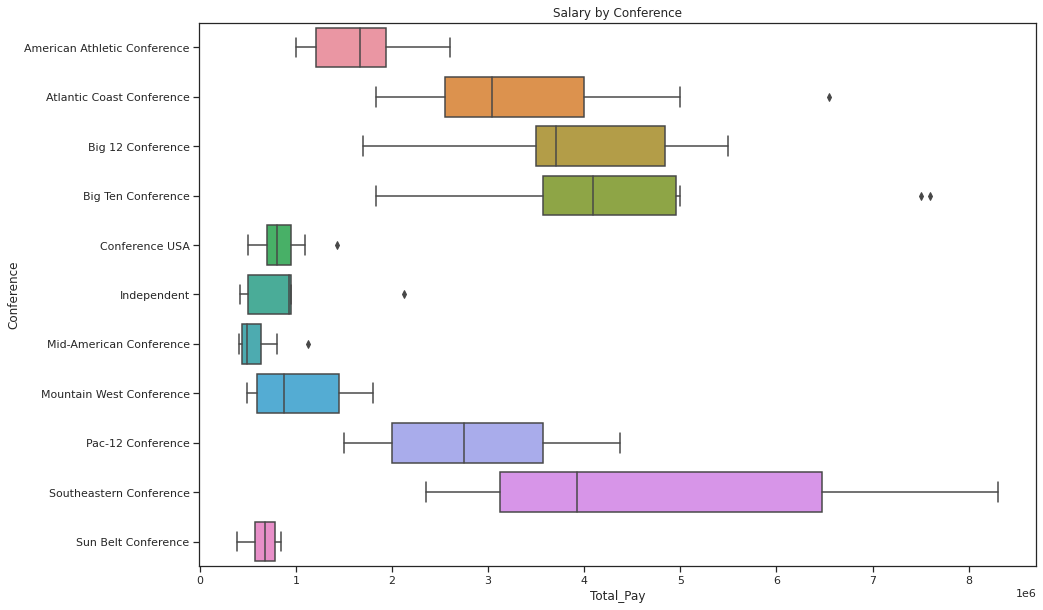

In [ ]:

plt.figure(figsize=(15,10))
sns.set(style="ticks", palette="bright")
sns.boxplot(x='Total_Pay',
               y='Conference', 
              data=SalaryDF) 
 
plt.title('Salary by Conference')


Text(0.5, 1.0, 'Salary by State')

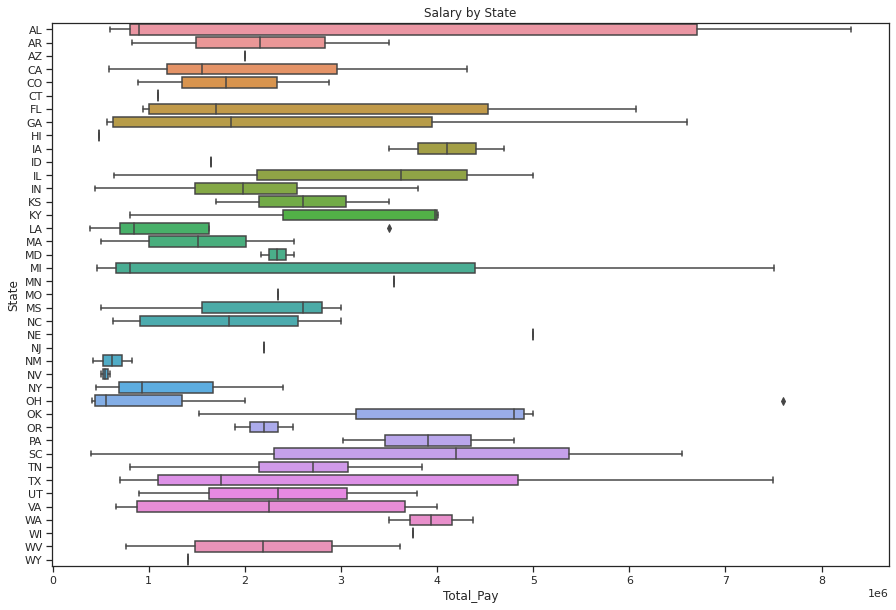

In [ ]:

plt.figure(figsize=(15,10))
sns.set(style="ticks", palette="bright")
sns.boxplot(x='Total_Pay',
               y='State', 
              data=SalaryDF) 
 
plt.title('Salary by State')

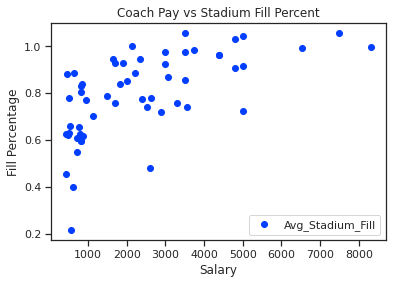

In [ ]:
SalaryDF.plot(x='Pay_000', y='Avg_Stadium_Fill', style='o')  
plt.title('Coach Pay vs Stadium Fill Percent')  
plt.xlabel('Salary')  
plt.ylabel('Fill Percentage')  
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


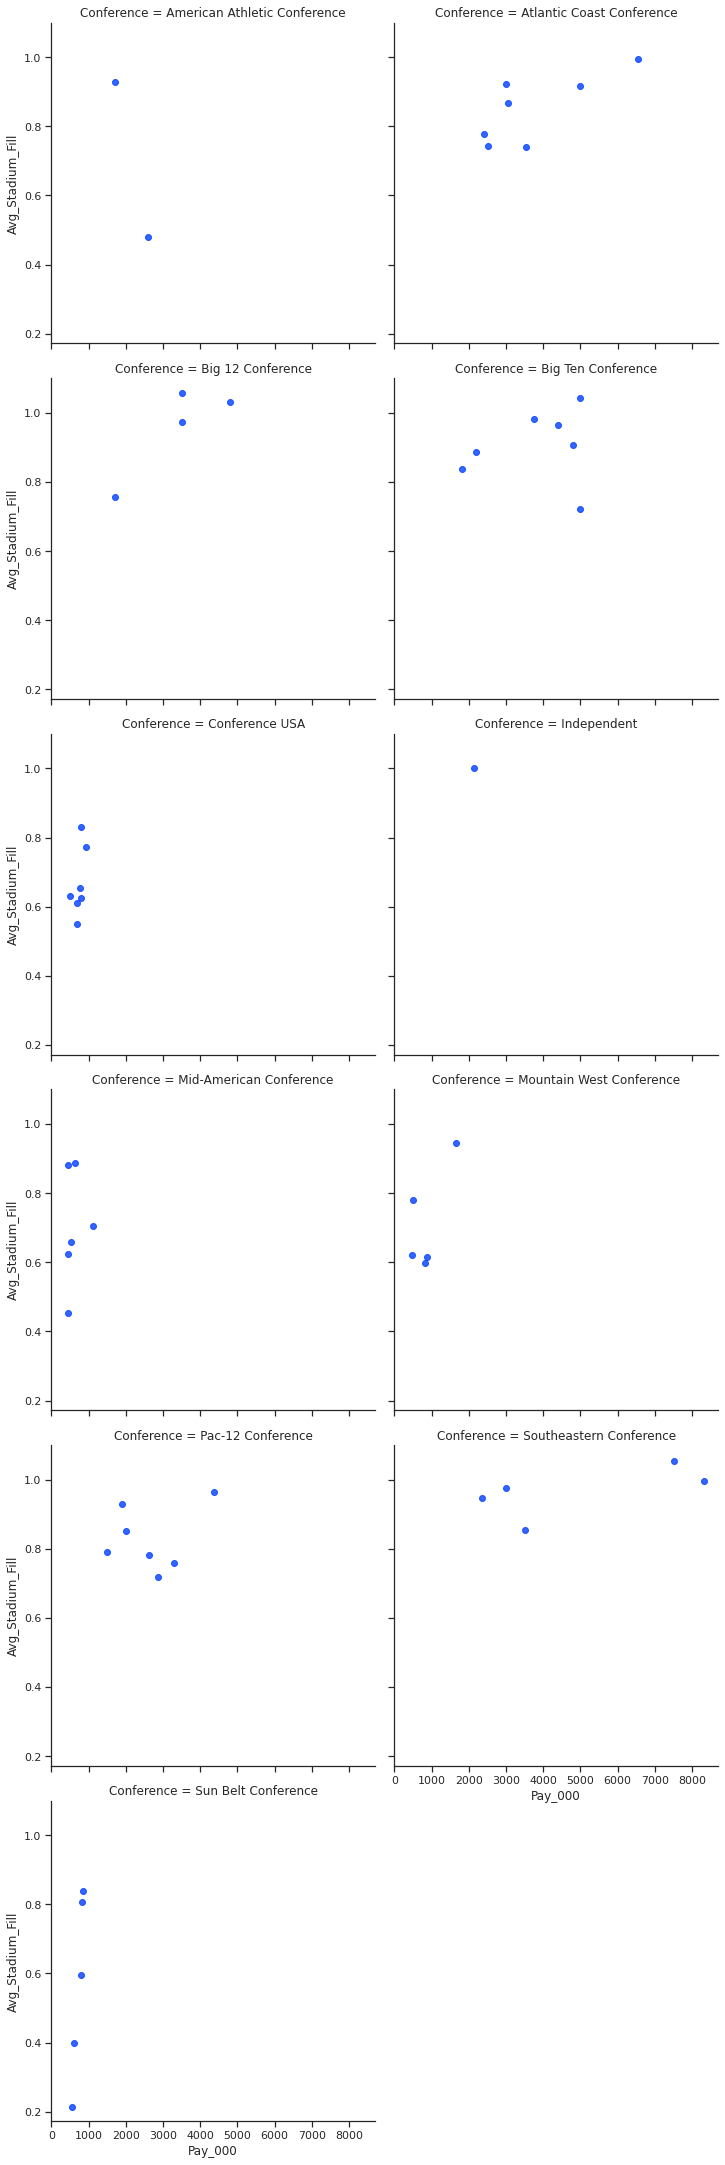

In [ ]:
sns.lmplot("Pay_000", "Avg_Stadium_Fill", data=SalaryDF, fit_reg=False, col='Conference', col_wrap=2)

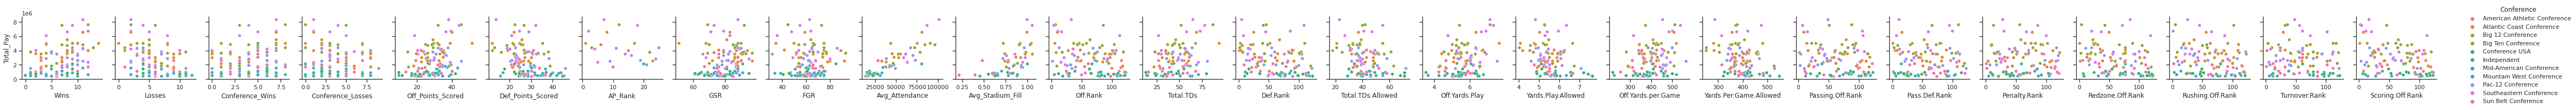

In [ ]:
pp = sns.pairplot(data=SalaryDF,
                  y_vars=['Total_Pay'],
                  x_vars=['Wins', 'Losses',
 'Conference_Wins', 'Conference_Losses', 'Off_Points_Scored',
 'Def_Points_Scored' ,'AP_Rank', 'GSR', 'FGR', 'Avg_Attendance', 'Avg_Stadium_Fill', 'Off.Rank', 'Total.TDs', 'Def.Rank',
 'Total.TDs.Allowed', 'Off.Yards.Play', 'Yards.Play.Allowed',
 'Off.Yards.per.Game','Yards.Per.Game.Allowed', 'Passing.Off.Rank',
 'Pass.Def.Rank', 'Penalty.Rank', 'Redzone.Off.Rank', 'Rushing.Off.Rank',
 'Turnover.Rank', 'Scoring.Off.Rank'], hue='Conference')

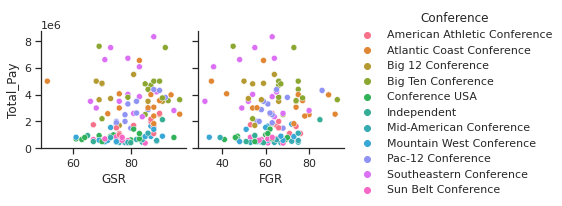

In [ ]:
plotss = sns.pairplot(data=SalaryDF,
                  y_vars=['Total_Pay'],
                  x_vars=[ 'GSR', 'FGR'], hue='Conference')
plotss.savefig('myplot.jpg', dpi=150)

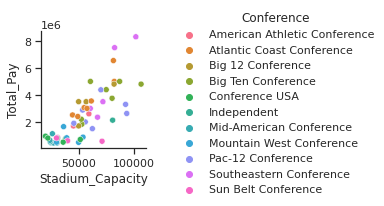

In [ ]:
plotsss = sns.pairplot(data=SalaryDF,
                  y_vars=['Total_Pay'],
                  x_vars=['Stadium_Capacity'], hue='Conference')
plotsss.savefig('myplot2.jpg', dpi=150)

In [ ]:
print(SalaryDF.columns.values)


['School' 'State' 'Conference' 'Coach' 'Total_Pay' 'Wins' 'Losses'
 'Conference_Wins' 'Conference_Losses' 'Off_Points_Scored'
 'Def_Points_Scored' 'AP_Rank' 'GSR' 'FGR' 'Avg_Attendance'
 'Stadium_Capacity' 'Avg_Stadium_Fill' 'Off.Rank' 'Total.TDs' 'Def.Rank'
 'Total.TDs.Allowed' 'Off.Yards.Play' 'Yards.Play.Allowed'
 'Off.Yards.per.Game' 'Yards.Per.Game.Allowed' 'Passing.Off.Rank'
 'Pass.Def.Rank' 'Penalty.Rank' 'Redzone.Off.Rank' 'Rushing.Off.Rank'
 'Turnover.Rank' 'Scoring.Off.Rank' 'Pay_000']


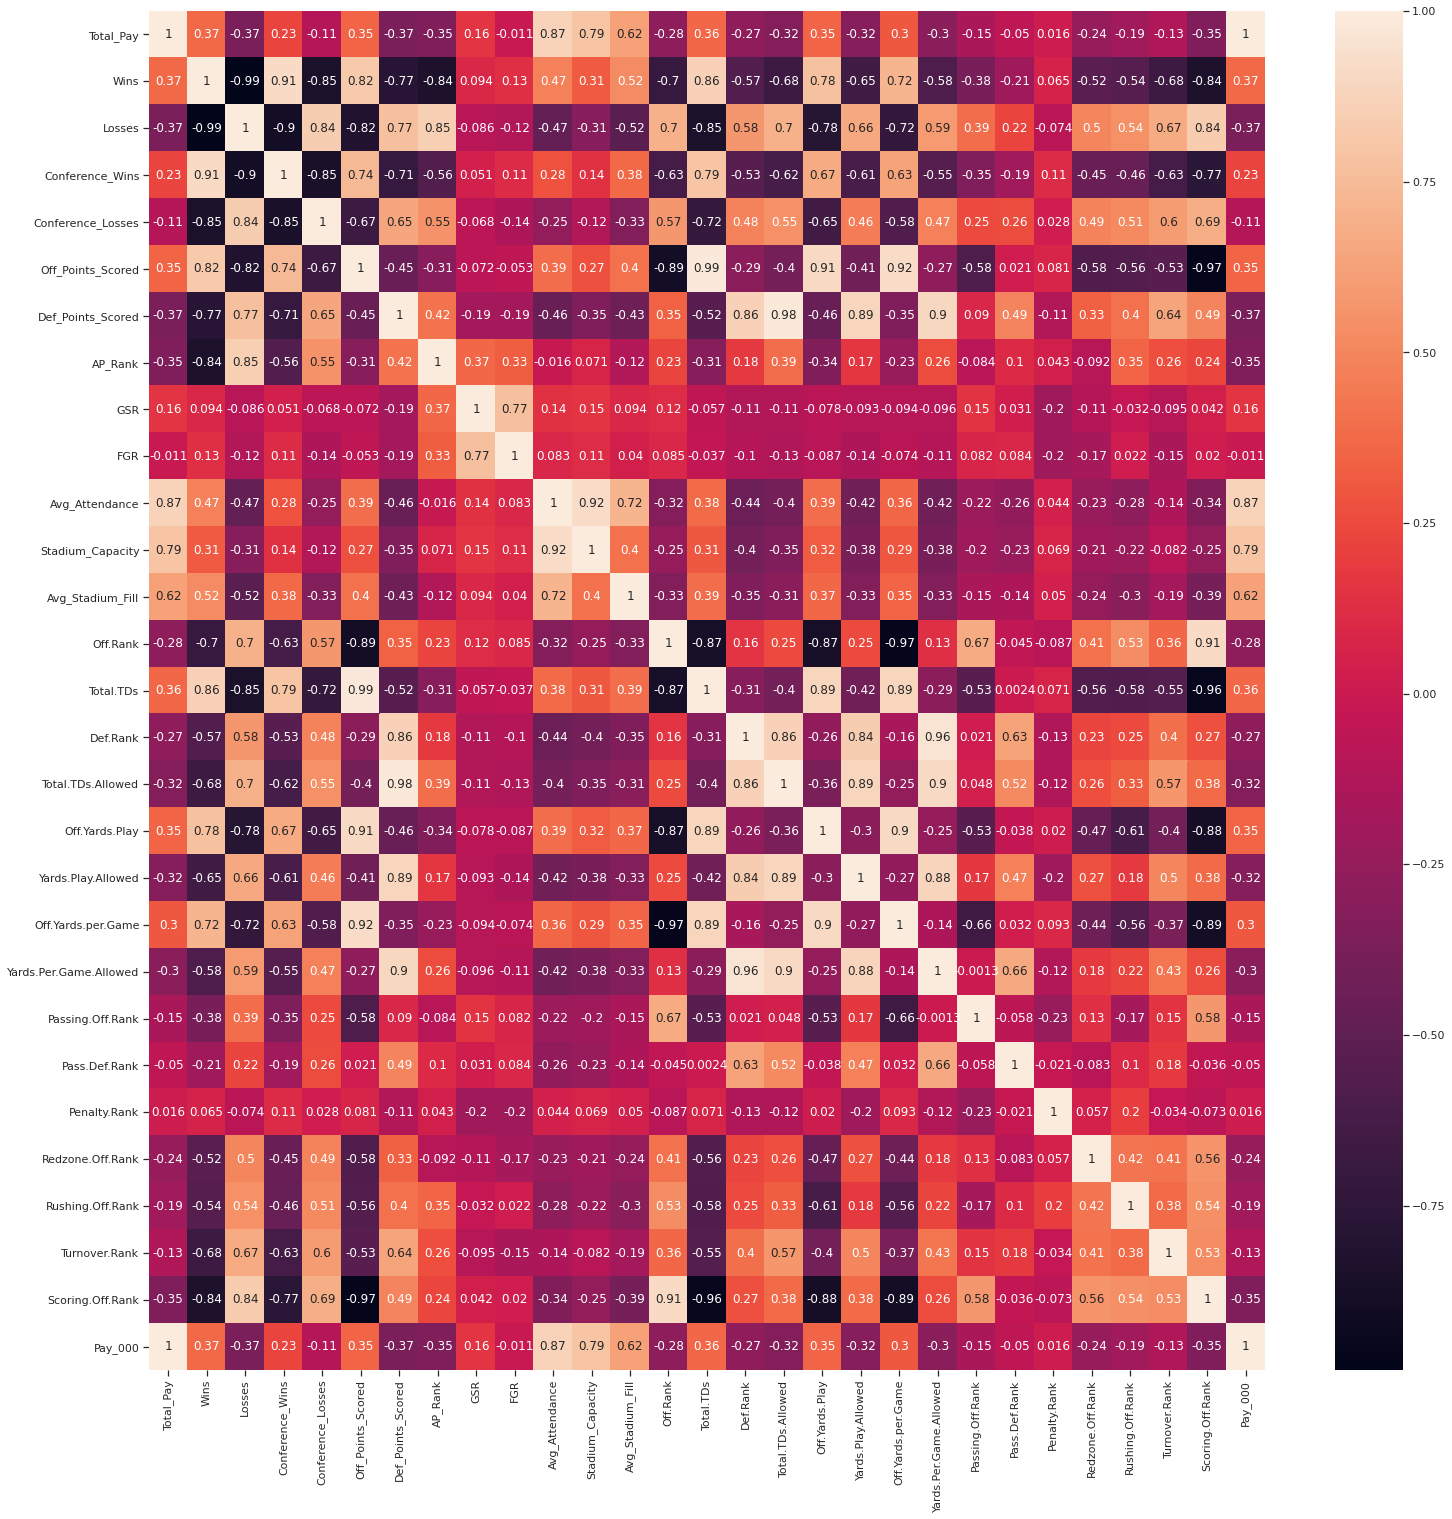

In [ ]:
#Explored the correlation between variables within the DF

fig, ax = plt.subplots(figsize=(25,25))
corrMatrix = SalaryDF.corr()
x=sns.heatmap(corrMatrix, annot=True, ax=ax)

In [ ]:
#cleaning
SalaryDF.columns = SalaryDF.columns.str.replace(".", "_")
SalaryDF.columns


Index(['School', 'State', 'Conference', 'Coach', 'Total_Pay', 'Wins', 'Losses',
       'Conference_Wins', 'Conference_Losses', 'Off_Points_Scored',
       'Def_Points_Scored', 'AP_Rank', 'GSR', 'FGR', 'Avg_Attendance',
       'Stadium_Capacity', 'Avg_Stadium_Fill', 'Off_Rank', 'Total_TDs',
       'Def_Rank', 'Total_TDs_Allowed', 'Off_Yards_Play', 'Yards_Play_Allowed',
       'Off_Yards_per_Game', 'Yards_Per_Game_Allowed', 'Passing_Off_Rank',
       'Pass_Def_Rank', 'Penalty_Rank', 'Redzone_Off_Rank', 'Rushing_Off_Rank',
       'Turnover_Rank', 'Scoring_Off_Rank', 'Pay_000'],
      dtype='object')

In [ ]:
#created a model for the Salary DF with multiple variables
np.random.seed(4202)
model_1 = str('Total_Pay ~ Conference + Wins +	Avg_Attendance + Total_TDs + Total_TDs_Allowed')
model_1_fit = smf.ols(model_1, data = SalaryDF).fit()
print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Total_Pay   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     14.81
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           1.01e-10
Time:                        04:26:14   Log-Likelihood:                -747.24
No. Observations:                  50   AIC:                             1522.
Df Residuals:                      36   BIC:                             1549.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [ ]:
linear_regression=LinearRegression()
linear_regression2=LinearRegression()

In [ ]:
#cleaning
testdata= SalaryDF[SalaryDF['Total_TDs'].notna()]
testdata= testdata[testdata['Avg_Attendance'].notna()]

In [ ]:
#created a separate dataset for just syracuse for getting the estimated salary
syracuse= testdata[testdata['School']=='Syracuse']
big10=testdata[testdata['Conference']=='Big Ten Conference']
big10

School State          Conference           Coach  Total_Pay  \
40         Illinois    IL  Big Ten Conference     Lovie Smith  5000000.0   
41          Indiana    IN  Big Ten Conference       Tom Allen  1830000.0   
61   Michigan State    MI  Big Ten Conference   Mark Dantonio  4390417.0   
68         Nebraska    NE  Big Ten Conference     Scott Frost  5000000.0   
86       Penn State    PA  Big Ten Conference  James Franklin  4800000.0   
89          Rutgers    NJ  Big Ten Conference       Chris Ash  2200000.0   
123       Wisconsin    WI  Big Ten Conference     Paul Chryst  3750000.0   

     Wins  Losses  Conference_Wins  Conference_Losses  Off_Points_Scored  \
40    4.0     8.0              1.0                7.0               29.7   
41    5.0     7.0              3.0                5.0               38.4   
61   13.0     1.0              8.0                0.0               29.4   
68    9.0     4.0              5.0                3.0               31.9   
86    7.0     5.0              4.0                4.0               28.7   
89    6.0     7.0              3.0                5.0               26.5   
123   9.0     4.0              6.0                2.0               34.8   

     Def_Points_Scored  AP_Rank   GSR   FGR  Avg_Attendance  Stadium_Capacity  \
40                35.4      NaN  90.0  75.0    43786.571429           60670.0   
41                38.8      NaN  88.0  63.0    44352.875000           52929.0   
61                13.2      3.0  86.0  75.0    72327.714286           75005.0   
68                24.8      NaN  88.0  66.0    90933.250000           87147.0   
86                26.2      NaN  85.0  67.0    96587.428571          106572.0   
89                29.8      NaN  70.0  54.0    46549.428571           52454.0   
123               16.3     22.0  91.0  77.0    78911.142857           80321.0   

     Avg_Stadium_Fill  Off_Rank  Total_TDs  Def_Rank  Total_TDs_Allowed  \
40           0.721717      46.0       45.0     110.0               55.0   
41           0.837969       9.0       62.0     120.0               63.0   
61           0.964305      80.0       51.0       2.0               21.0   
68           1.043447      58.0       54.0      40.0               38.0   
86           0.906311      43.0       43.0      48.0               38.0   
89           0.887433      95.0       44.0      73.0               49.0   
123          0.982447      18.0       59.0       7.0               25.0   

     Off_Yards_Play  Yards_Play_Allowed  Off_Yards_per_Game  \
40             5.91                6.66               426.7   
41             6.58                6.74               508.5   
61             5.40                4.04               385.5   
68             5.57                5.21               412.4   
86             5.71                5.30               433.2   
89             5.29                5.68               365.2   
123            6.85                4.73               480.8   

     Yards_Per_Game_Allowed  Passing_Off_Rank  Pass_Def_Rank  Penalty_Rank  \
40                    481.5              22.0           81.0          65.0   
41                    527.9              17.0          118.0          44.0   
61                    252.2              82.0            3.0          78.0   
68                    370.8              95.0           33.0          82.0   
86                    381.3              37.0           73.0          10.0   
89                    412.8              62.0          120.0          90.0   
123                   305.1              93.0           17.0          19.0   

     Redzone_Off_Rank  Rushing_Off_Rank  Turnover_Rank  Scoring_Off_Rank  \
40               89.0              92.0            112              61.0   
41               62.0              30.0             79              16.0   
61               77.0              58.0             10              64.0   
68               24.0              19.0            117              48.0   
86               67.0              

In [ ]:
testdata.head()

School State               Conference           Coach  Total_Pay  \
2          Alabama    AL  Southeastern Conference      Nick Saban  8307000.0   
5          Arizona    AZ        Pac-12 Conference    Kevin Sumlin  2000000.0   
7         Arkansas    AR  Southeastern Conference     Chad Morris  3500000.0   
8   Arkansas State    AR      Sun Belt Conference  Blake Anderson   825000.0   
11      Ball State    IN  Mid-American Conference        Mike Neu   435689.0   

    Wins  Losses  Conference_Wins  Conference_Losses  Off_Points_Scored  \
2   11.0     2.0              7.0                1.0               38.2   
5    8.0     5.0              4.0                5.0               33.5   
7    3.0     9.0              0.0                8.0               20.7   
8    8.0     5.0              5.0                2.0               29.2   
11  10.0     3.0              7.0                1.0               38.5   

    Def_Points_Scored  AP_Rank   GSR   FGR  Avg_Attendance  Stadium_Capacity  \
2                13.9      7.0  88.0  63.0   101505.428571          101821.0   
5                24.2      NaN  78.0  56.0    47618.833333           56037.0   
7                30.8      NaN  76.0  52.0    61596.285714           72000.0   
8                26.2      NaN  77.0  53.0    24979.800000           30964.0   
11               24.7      NaN  76.0  64.0    13816.833333           30406.0   

    Avg_Stadium_Fill  Off_Rank  Total_TDs  Def_Rank  Total_TDs_Allowed  \
2           0.996901      33.0       65.0       5.0               23.0   
5           0.849775      31.0       57.0      62.0               39.0   
7           0.855504      99.0       30.0      76.0               49.0   
8           0.806737      65.0       48.0      74.0               43.0   
11          0.454411      19.0       64.0      77.0               39.0   

    Off_Yards_Play  Yards_Play_Allowed  Off_Yards_per_Game  \
2             7.15                4.83               454.1   
5             5.79                5.26               458.5   
7             5.53                6.09               357.2   
8             5.60                5.78               407.8   
11            6.46                5.58               477.1   

    Yards_Per_Game_Allowed  Passing_Off_Rank  Pass_Def_Rank  Penalty_Rank  \
2                    286.5              49.0           11.0          28.0   
5                    401.1              97.0           70.0          18.0   
7                    413.4             114.0           72.0          23.0   
8                    413.1              89.0           69.0         103.0   
11                   413.8              12.0           44.0           5.0   

    Redzone_Off_Rank  Rushing_Off_Rank  Turnover_Rank  Scoring_Off_Rank  \
2               85.0              25.0             48              17.0   
5               62.0              11.0             39              36.0   
7               91.0              21.0            111             105.0   
8               48.0              24.0             24              67.0   
11               9.0              79.0             12              15.0   

     Pay_000  
2   8307.000  
5   2000.000  
7   3500.000  
8    825.000  
11   435.689

In [ ]:
#training data and syracuse data for test
syr=syracuse[['Avg_Attendance', 'Total_TDs', 'Total_TDs_Allowed', 'Wins']]
X = testdata[['Avg_Attendance', 'Total_TDs', 'Total_TDs_Allowed', 'Wins']]
y = testdata['Total_Pay'].values.reshape(-1,1)

In [ ]:
#assigned regressors for Big 10
bigX = big10[['Avg_Attendance', 'Total_TDs', 'Total_TDs_Allowed', 'Wins']]
bigy = big10['Total_Pay'].values.reshape(-1,1)

In [ ]:
#linear regression for entire Data set
linear_regression.fit(X,y)
print('Intercept: \n', linear_regression.intercept_)
print('Coefficients: \n', linear_regression.coef_)

Intercept: 
 [576122.68253909]
Coefficients: 
 [[ 6.56621371e+01  3.60860697e+04 -2.72898053e+04 -2.34279067e+05]]


In [ ]:
#linear regression for big 10
linear_regression2.fit(bigX,bigy)
print('Intercept: \n', linear_regression2.intercept_)
print('Coefficients: \n', linear_regression2.coef_)

Intercept: 
 [6226700.60906318]
Coefficients: 
 [[ 2.96092628e+01 -5.87471500e+04 -2.17233809e+04 -6.27435642e+04]]


In [ ]:
#prediction for Syracuse coach
pred=linear_regression.predict(syr)
pred

array([[1674606.71873572]])

This model suggests that the Syracuse coach should recieve a salary of 1674607 dollars rounded.

In [ ]:
#Prediction if Syracuse was in the Big 10
pred=linear_regression2.predict(syr)
pred

array([[3776070.77903715]])

This indicates that if Syracuse was in the Big 10 the coach should make 3.7 million dollars

In [ ]:
#model conducted on the entire Salary DF
model_2 = str('Total_Pay ~ Wins +	Avg_Attendance + Total_TDs + Total_TDs_Allowed')
model_2_fit = smf.ols(model_2, data = SalaryDF).fit()
print(model_2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Total_Pay   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     38.97
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           4.44e-14
Time:                        06:38:14   Log-Likelihood:                -756.04
No. Observations:                  50   AIC:                             1522.
Df Residuals:                      45   BIC:                             1532.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.761e+05   1.19e+0

In [ ]:
#model for only a single variable used on the test data set that was much cleaner
model_3_fit = smf.ols(model_3, data = testdata).fit()
print(model_3_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Total_Pay   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     143.9
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           4.75e-16
Time:                        06:58:17   Log-Likelihood:                -758.80
No. Observations:                  50   AIC:                             1522.
Df Residuals:                      48   BIC:                             1525.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4.957e+05   2.89e+05     -1.